# Tutorial on combining `halophot`, `lightkurve` and `k2sc`

Let's work through how to apply halo photometry to data from the star Aldebaran, the brightest observed by TESS. We will acccess these data using the popular package `lightkurve`, and then first extract photometry with `halophot`, and correct residual systematics with the Oxford detrender `k2sc`.

In [1]:
import numpy as np
import matplotlib 
import matplotlib as mpl

import halophot
from halophot.halo_tools import halo_tpf

import lightkurve as lk

import k2sc 

from astropy.table import Table

%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['figure.figsize']=(10.0,10.0)    #(6.0,4.0)
matplotlib.rcParams['font.size']=16              #10 
matplotlib.rcParams['savefig.dpi']= 300             #72 
colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']
from mpl_toolkits.axes_grid1 import make_axes_locatable

print(lk.__version__)
print(k2sc.__version__)
print(halophot.__version__)

Populating the interactive namespace from numpy and matplotlib
2.0.11.to_fits
1.0.2
0.7.4.6


Let's load the data.

<AxesSubplot:title={'center':'Target ID: 200173843, Cadence: 140879'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

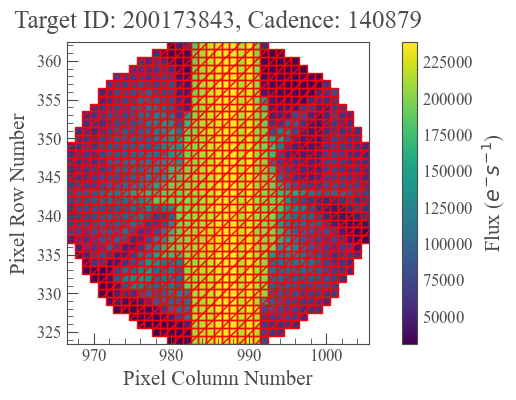

In [2]:
fname = "../data/ktwo200173843-c13_lpd-targ.fits.gz" # aldebaran
tpf = halo_tpf(fname)
tpf.plot(frame=1,aperture_mask=tpf.pipeline_mask)

How does the raw light curve look without halo? Pretty rubbish!

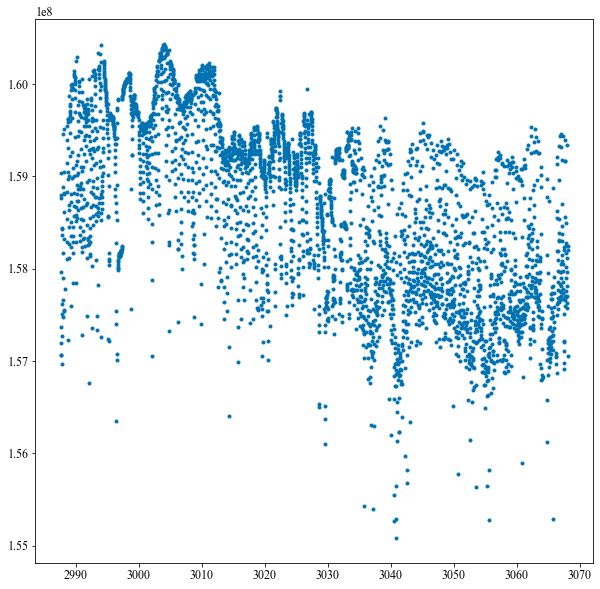

In [3]:
lc = tpf.to_lightcurve()
plt.plot(lc.time.value, lc.flux,'.')


## Now to do Halophot!

We let's now open the filename as a `halo_tpf` object, which is a thin wrapper around `lightkurve.targetpixelfile` which allows us `halophot` to access its attributes.


In [4]:
tpf = halo_tpf(fname)

Now we just run `halophot` as the method `tpf.halo` - we can have it separately optimize weights in two sections of the time series, which we find is helpful because of the way K2 systematics change over the course of a campaign. This will return a metadata dictionary, which includes our weightmap(s), and a `lightkurve.lightcurve` object with the optimized light curve.

In [5]:
%%time
meta, corr_lc = tpf.halo(split_times=[3010],thresh=0.5);
weightmap = meta['weightmap'][0]

Taking cadences from beginning to 1027
497 saturated pixels
Throwing out 2 bad cadences
Censored TPF
Subsampling by a factor of 1
Calculating weights
Using Analytic Derivatives
Calculated weights!
Taking cadences from 1027 to end
493 saturated pixels
Throwing out 1 bad cadences
Censored TPF
Subsampling by a factor of 1
Calculating weights
Using Analytic Derivatives
Calculated weights!
CPU times: user 10.2 s, sys: 2.19 s, total: 12.4 s
Wall time: 4.25 s


/Users/benjaminpope/opt/anaconda3/lib/python3.8/site-packages/halophot-0.7.4.6-py3.8.egg/halophot/halo_tools.py:1157: UserWarning: Lightkurve doesn't allow columns or meta values to be created via a new attribute name.A new attribute is created. It will not be carried over when the object is copied. - see https://docs.lightkurve.org/reference/api/lightkurve.LightCurve.html
/Users/benjaminpope/opt/anaconda3/lib/python3.8/site-packages/halophot-0.7.4.6-py3.8.egg/halophot/halo_tools.py:1158: UserWarning: Lightkurve doesn't allow columns or meta values to be created via a new attribute name.A new attribute is created. It will not be carried over when the object is copied. - see https://docs.lightkurve.org/reference/api/lightkurve.LightCurve.html
/Users/benjaminpope/opt/anaconda3/lib/python3.8/site-packages/halophot-0.7.4.6-py3.8.egg/halophot/halo_tools.py:1160: UserWarning: Lightkurve doesn't allow columns or meta values to be created via a new attribute name.A new attribute is created. It

Let's plot the results - light curve on the left, and weightmap on the right! Looking good!

<ipython-input-6-767af343ca8c>:11: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("seismic"))
  cmap.set_bad('k',1.)


Text(0.5, 1.0, 'TV-min Weightmap')

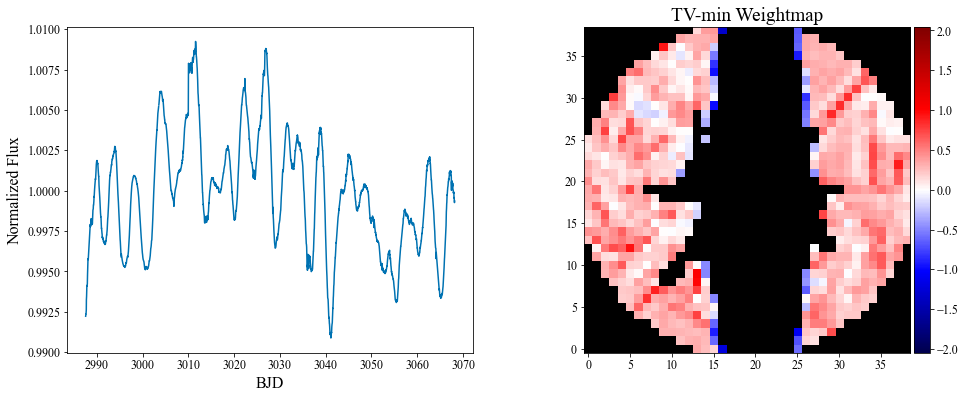

In [6]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16.0,6.0))

ax1.plot(corr_lc.time.value,corr_lc.flux)
ax1.set_ylabel('Normalized Flux')
ax1.set_xlabel('BJD')
ax2.set_title('Light Curve')

cmap = mpl.cm.seismic
norm = np.size(weightmap)

cmap.set_bad('k',1.)
im = np.log10(weightmap.T*norm)
im2 = ax2.imshow(im,cmap=cmap, vmin=-2*np.nanmax(im),vmax=2*np.nanmax(im),
    interpolation='None',origin='lower')
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical');

ax2.set_title('TV-min Weightmap')

You can read and write these files just as you would normally.

In [7]:
from astropy.io import fits

f = fits.PrimaryHDU(weightmap)
f.writeto('aldebaran_weightmap.fits',overwrite=True)

corr_lc.to_fits('aldebaran_test.fits',overwrite=True)
test_lc = lk.read('aldebaran_test.fits')

There are some small residual systematics here. Now let's try and correct it with `k2sc` to remove even the last systematics. We just clobber the class of the lightcurve to be a `k2sc_lc` from `k2sc.standalone`, the `k2sc` interface to `lightkurve`. 

In [8]:
import k2sc
from k2sc.standalone import k2sc_lc

corr_lc.__class__ = k2sc_lc

In [9]:
corr_lc.k2sc()

/Users/benjaminpope/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/benjaminpope/opt/anaconda3/lib/python3.8/site-packages/K2SC-1.0.2-py3.8.egg/k2sc/standalone.py:293: LightkurveDeprecationWarning: The hdu function is deprecated and may be removed in a future version.
        Use fits.open(lc.filename) instead.


Using default splits [2998, 3033] for campaign 13


  0%|          | 0/150 [00:00<?, ?it/s]

Starting initial outlier detection
  Flagged 3 ( 0.1%) outliers.
Starting Lomb-Scargle period search
  Using SqrExp position kernel
  Found periodicity p =    5.75 (fap 2.7709e-179 < 1e-50), will use a quasiperiodic kernel
Starting global hyperparameter optimisation using DE


 71%|███████   | 106/150 [05:00<02:04,  2.83s/it, -ln(L)=-5636.1]


  DE finished in 300 seconds
  DE minimum found at: [-5.574  0.989  0.932  1.433 -5.734  0.861 12.926 -4.174]
  DE -ln(L) -5636.1
Starting local hyperparameter optimisation
  Local minimum found at: [-5.564  0.996  0.809  1.832 -6.     1.333 13.064 -4.177]
Starting final outlier detection
     24 too high
     32 too low
      3 not finite
Computing time and position trends
  CDPP - raw - 166.354
  CDPP - position component removed - 165.480
  CDPP - full reduction - 22.048
Detrending time 322.74713492393494


Now let's plot the light curve - how did the `k2sc` correction go?

/Users/benjaminpope/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.01, 'Aldebaran')

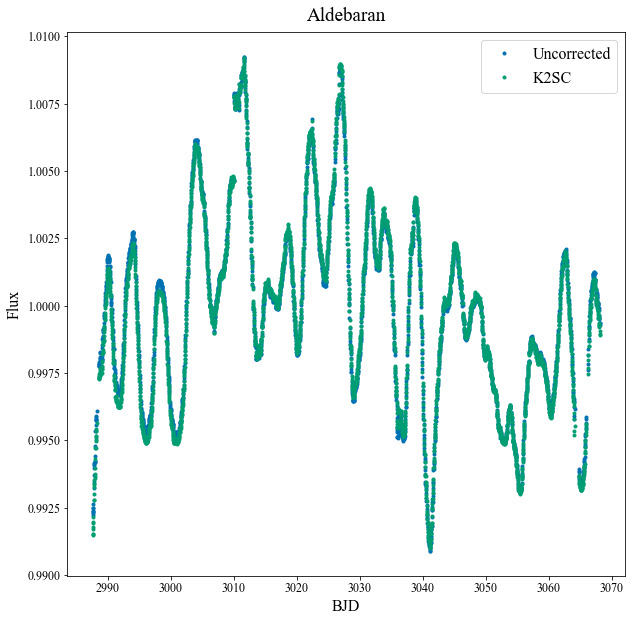

In [11]:
plt.plot(corr_lc.time.value,corr_lc.flux.value,'.',label="Uncorrected")
plt.plot(corr_lc.time.value,corr_lc.corr_flux.value,'.',label="K2SC")
plt.legend()
plt.xlabel('BJD')
plt.ylabel('Flux')
plt.title('Aldebaran',y=1.01)